## Ryan - Unsupervised. 
Preprocessed data (dimreduced and subsetted) is passed through a clustering pipeline and visualized at each step.



### Set path

In [90]:
# os allows the invokation of the file path in python
'''Here I call the file path, split it into a list of strings using the '/' delimiter, and add the 'CS329E-Project' to 
the end of the file path. '''
import os
path = []
print(os.getcwd())
for i in (os.getcwd()).split('/'):
    if i != '':
        path.append(i)
    if i == 'CS329E-Project':
        break
path = '/' + '/'.join(path)
os.chdir(path)
print(os.getcwd())


/Users/ryanbailey/Documents/GitHub/CS329E-Project
/Users/ryanbailey/Documents/GitHub/CS329E-Project


In [91]:
# some imports are provided here for you
# you may add additional imports if needed
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random as rand
import itertools as it
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from pandas import DataFrame, Series
import scipy
import matplotlib.cm as cm
from scipy.cluster import hierarchy as hier
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE as tsne
from sklearn.manifold import MDS
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.model_selection import StratifiedKFold

In [92]:
%matplotlib inline


In [93]:
#import dataset from path
data = pd.read_csv("Datasets/Preprocessed/data_subset_normalized_iqr_99_per_labels.csv", header = 0)
# import dataset must have a labels feature
labels = data['Labels']
# drop the patient barcodes and Labels from the dataframe
data = data.drop(['Unnamed: 0','Labels'], axis = 1)

print(data.shape)
data.head()

(388, 321)


ILMN_1652199  ILMN_1652230  ILMN_1652431  ILMN_1652955  ILMN_1654118  \
0      1.470393     -1.241466     -0.660810     -1.598497      0.984219   
1     -0.032642     -1.871644     -1.113843     -0.868280      0.232853   
2      1.227080      0.162089     -0.009085      0.027138      1.331133   
3     -0.762239     -0.723636      1.994674     -0.806518      1.788300   
4      0.561888     -0.046400      0.872846      0.132239      1.002342   

   ILMN_1654875  ILMN_1656625  ILMN_1656807  ILMN_1657722  ILMN_1657932  ...  \
0     -2.118200     -1.291460     -1.266995     -1.953643      1.359487  ...   
1     -2.102576     -0.739728     -2.181416     -0.651325      0.328018  ...   
2     -0.513828     -0.285437     -0.047546     -0.093371      0.462415  ...   
3     -0.639978     -1.058331     -0.869720     -0.996756      1.311987  ...   
4      0.454382      0.239130      0.459120      1.018243      1.410526  ...   

   ILMN_3291986  ILMN_3292678  ILMN_3293676  ILMN_3296994  ILMN_3299187  \
0     -0.944737     -1.451080     -1.831764     -1.036037     -1.727719   
1     -1.797841     -1.156623     -0.887486     -0.098060     -0.350046   
2     -0.044051     -0.172240     -0.089173     -1.593592     -0.072162   
3     -0.716408     -0.987224     -0.631216      1.266616     -1.088215   
4      0.000940      0.746865      0.598165      0.753966      1.201899   

   ILMN_3299955  ILMN_3301324  ILMN_3307868  ILMN_3308961  ILMN_3310491  
0     -1.075620     -1.488925     -1.455966      0.051400     -0.243922  
1      0.471352     -0.486000      0.752539     -0.543983      0.747304  
2     -1.334810     -0.157426     -0.736910     -0.368736     -1.113792  
3      0.943090     -1.097160      0.273720      0.862317      0.077708  
4      0.223129      0.435398      1.328132      2.055724      2.311811  

[5 rows x 321 columns]

# Outline of Script
### 1. Visualize distribution of data by class
### 2. Perform DBSCAN on data and visualize the results
### 3. Perform Kmeans++ on data and visualize the results
### 4. Perform HAC on data and visualize the results
### 5. Interpret the results in context

## Dimensionality reduction for input data
Many clustering methods suffer from the curse of dimensionality. It is also impossible to visualize data in more than three dimensions. The following function exists to reduce the dimensionality of the input data to a point where it can be visualized.

In [148]:
# this function, when passed a pandas dataframe will return a dimensionality reduced dataset either as a numpy array
# or as a pandas dataframe
# dim controls the number of features in the dim reduced dataset
# key controls which dimensionality reduction algorithm is used
def dim_reduct_for_plot(data,key='pca',dim=2,ret_df = False):
    if key == 'pca':
        pca = PCA(n_components = dim)
        ret = pca.fit_transform(data)
    elif key == 'tsne':
        model = tsne(n_components = dim,learning_rate =15)
        ret = model.fit_transform(data)
    elif key == 'MDS':
        mds = MDS(n_components=dim)
        ret = mds.fit_transform(data.iloc[:, :-1])
    if ret_df == True:
        ret = DataFrame(ret)
    return ret


The following function can plot data into 2D or 3D scatter plots

## 1. Visualize distribution of data by class.
Projecting data into a two or three dimensional space via PCA, tSNE, or MDS and showing the class association of each data point should help us gauge the clustering tendency of the dataset. 

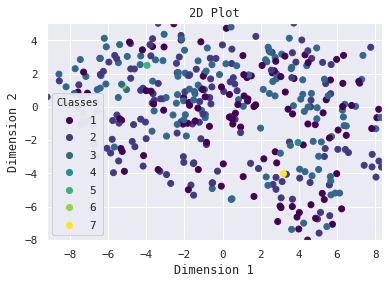

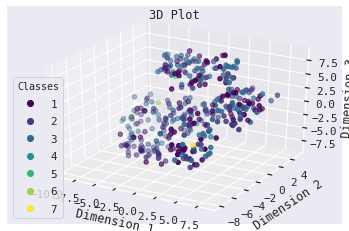

In [191]:
# General

def plot(data,labels,dim = 2,title = ''):
    if dim == 2:
        
        fig, ax = plt.subplots()

        scatter1 = ax.scatter(data[:, 0], data[:, 1], c=labels,marker='o',cmap=cm.viridis)

        # produce a legend with the unique colors from the scatter
        legend1 = ax.legend(*scatter1.legend_elements(),
                            loc="lower left", title="Classes")
        ax.add_artist(legend1)
        plt.xlabel('Dimension 1')
        plt
        plt.ylabel('Dimension 2')
        plt.title(title)
        plt.autoscale(enable=True, axis='both', tight=True)

    if dim == 3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel('Dimension 1')
        ax.set_ylabel('Dimension 2')
        ax.set_zlabel('Dimension 3')
        scatter1 = ax.scatter(data[:, 0], data[:, 1],data[:,2], c=labels,marker='o',cmap=cm.viridis)
        legend1 = ax.legend(*scatter1.legend_elements(),
                            loc="lower left", title="Classes")
        plt.xlim(-75,  75)
        plt.ylim(-75, 75)
        plt.title(title)
        plt.autoscale(enable=True, axis='both', tight=True)
        return plt
visdata = dim_reduct_for_plot(data,key='tsne',dim=3)
plot(visdata,labels,dim=2,title='2D Plot')
plot(visdata,labels,dim=3,title='3D Plot').show()

The following function can create interactive 3D scatter plots from input data.

In [192]:
def interactive_3d(data,labels,symb = None,op = 0.4):
    if type(data) != 'pandas.core.frame.DataFrame':
        data = DataFrame(data)
    import plotly.express as px
    import plotly.graph_objects as go
    fig = px.scatter_3d(data, x=0 , y=1, z=2, color=labels, symbol= symb,opacity = op)
    fig.show()

interactive_3d(visdata,labels)

### 2. Perform DBSCAN on data and visualize the results
Now that we have an idea of how the data 'looks,' we can begin our analyses. First we will be using DBSCAN to cluster data based on density. This algorithm suffers from the curse of dimensionality, so it is unlikely to be informative on versions of our data with lots of features.

We will be basing our definition of density of the distance to the fourth nearest neighbor of each point. Plotting 4th NN Distance against the indices of points sorted by their distances to their fourth nearest neighbors. That will help us to determine an appropriate eps and min_pts for the dataset.

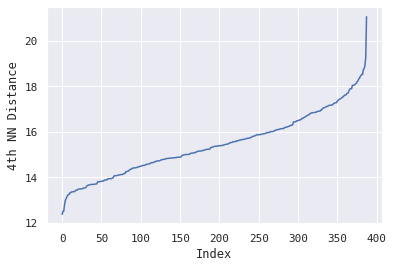

In [193]:
from sklearn.neighbors import NearestNeighbors as NN
num = 4
NN = NN(n_neighbors = num)
NN.fit(data)
distances,indices = NN.kneighbors(n_neighbors = num)
distances = np.sort(distances, axis=0)
distances = distances[:,num-1]
cutoff =  (len(distances)) - (len(distances) // 5)
eps1 = (distances[cutoff])
plt.plot(distances)
plt.xlabel('Index')
plt.ylabel('4th NN Distance')
plt.show()

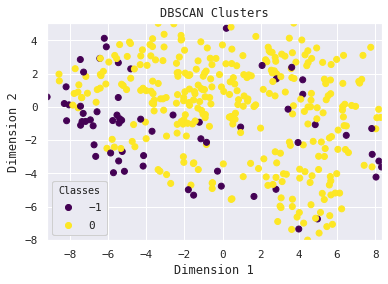

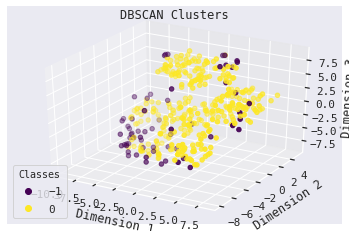

In [205]:
#your code goes here
from sklearn.cluster import DBSCAN
DBSCAN = DBSCAN(eps=eps1, min_samples=40)
pred = pd.Series(DBSCAN.fit_predict(data))
plot(visdata,pred,dim=2,title = 'DBSCAN Clusters')
plot(visdata,pred,dim=3,title = 'DBSCAN Clusters')
interactive_3d(visdata,pred_labels,symb=labels)


### Interpretation of DBSCAN
Our visualization helps to show the mechanism of DBSCAN. It finds two clusters in our dataset, one is very compact while one is very diffuse. Perhaps it would be able to suss out more defined clusters in the data if a heavily dimensionality reduced dataset was passed. Since our visualization is performed on tSNE data, it is not possible to interpret the variation in our dataset.

### 3. Perform Kmeans++ on data and visualize the results
As was the case with DBSCAN, we need to understand our data before attempting to cluster it. Sci-Kit Learn makes it very easy to extract silhouette scores and cluster sum of squared error (SSE) for each value of K. Plotting these values for each K creates an 'elbow plot.' The best clusters have the samples with high silhouette scores and have low SSE. The elbow in the elbow plot is the optimal K for our data.

For n_clusters = 2 The average silhouette_score is: 0.22773923455545303
For n_clusters = 3 The average silhouette_score is: 0.14625225796056454
For n_clusters = 4 The average silhouette_score is: 0.12842678308797847
For n_clusters = 5 The average silhouette_score is: 0.11604707999619192
For n_clusters = 6 The average silhouette_score is: 0.10899118275104103
For n_clusters = 7 The average silhouette_score is: 0.10507518300106111
For n_clusters = 8 The average silhouette_score is: 0.10307316474548797
For n_clusters = 9 The average silhouette_score is: 0.1059753112278208
For n_clusters = 10 The average silhouette_score is: 0.09856323322751173
For n_clusters = 11 The average silhouette_score is: 0.09291253886104163
For n_clusters = 12 The average silhouette_score is: 0.08392444998170226


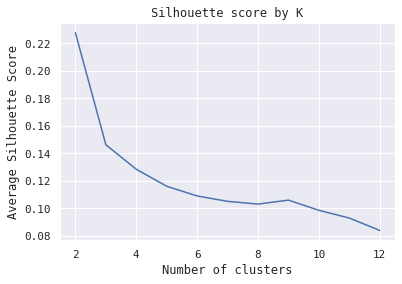

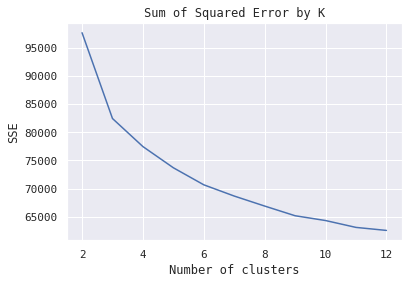

In [195]:
# your code goes here
from sklearn.metrics import silhouette_score as SS
from sklearn.cluster import KMeans
s_score_list = []
clusts = range(2, 13)
for n_clusters in clusts:
    KM = KMeans(n_clusters = n_clusters)
    pred = pd.Series(KM.fit_predict(data))
    silhouette_avg = silhouette_score(data, pred)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is:", silhouette_avg)
    s_score_list.append(silhouette_avg)
s_score_array = np.asarray(s_score_list)
plt.xlabel("Number of clusters")
plt.title('Silhouette score by K')
plt.ylabel("Average Silhouette Score")
plt.plot(clusts,s_score_array)
plt.show()

sse = {}
for k in range(2, 13):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.title('Sum of Squared Error by K')
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()


K = 2 would produce the highest silhouette scores but SSE is reduced with each increase in K until K > 6. We will choose the K that gives the highest silhouette scores: K = 2.

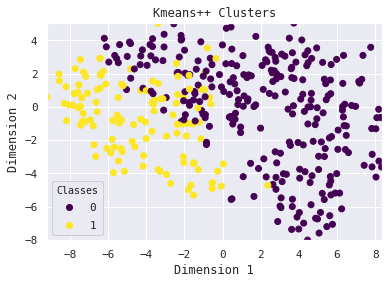

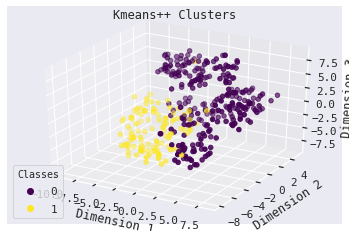

In [206]:
bestK = clusts[(s_score_list.index(max(s_score_list)))]
KM = KMeans(n_clusters = bestK)
pred = pd.Series(KM.fit_predict(data))
plot(visdata,pred,dim=2, title = 'Kmeans++ Clusters')
plot(visdata,pred,dim=3,title = 'Kmeans++ Clusters')
interactive_3d(visdata,pred,symb=labels,op=1.0)


The Kmeans++ clusters appear to be very different from the DBSCAN clusters. It's obvious how the Kmeans++ centroid initialization creates globular clusters. Since our visualization is performed on tSNE data, it is not possible to interpret the variation in our dataset.

## Kmeans++ in feature space.
Silhouette plots paired with data plotted in 2D feature space. The silhouette plot shows the cluster membership of each sample and is color-coded to show cluster identity.

Here I call the file path, split it into a list of strings using the '/' delimiter, and add the 'CS329E-Project' to 
the end of the file path. 
For n_clusters = 2 The average silhouette_score is : 0.50735843
For n_clusters = 3 The average silhouette_score is : 0.44833893
For n_clusters = 4 The average silhouette_score is : 0.43395483
For n_clusters = 5 The average silhouette_score is : 0.4374931


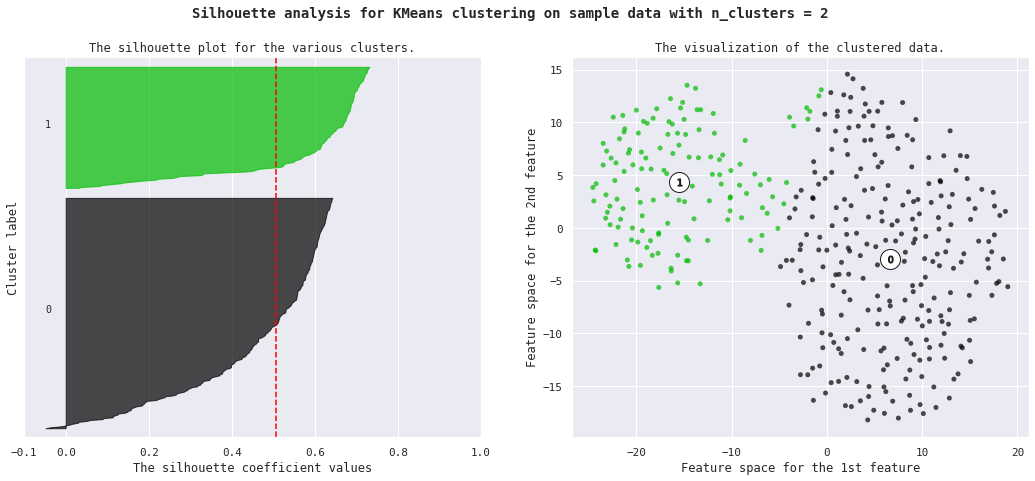

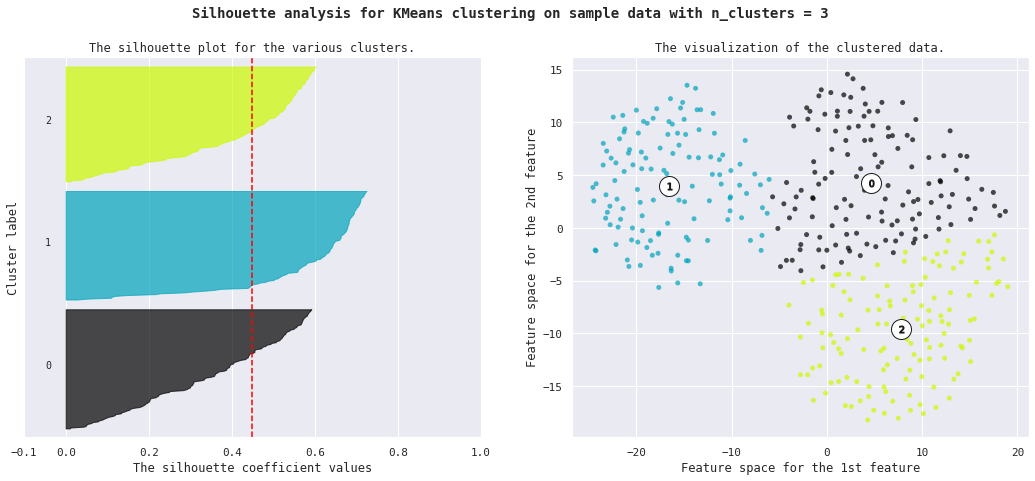

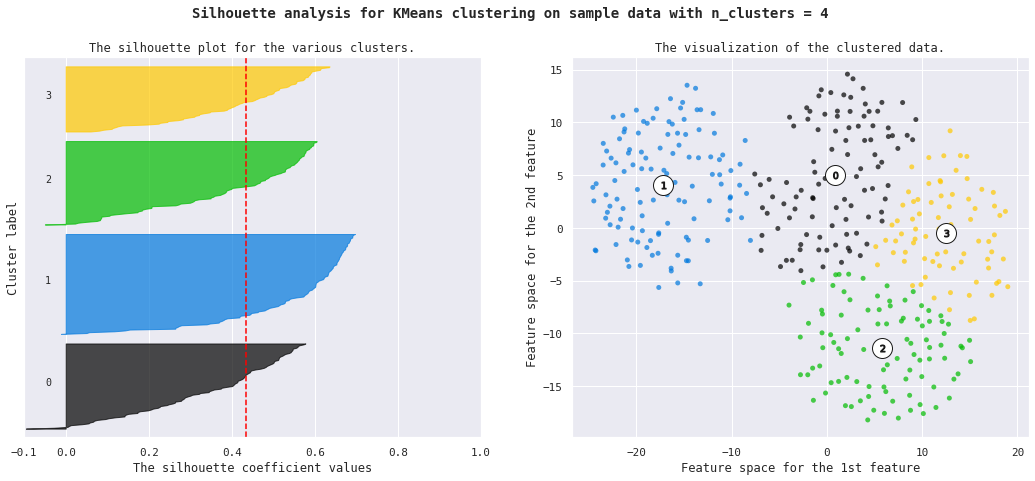

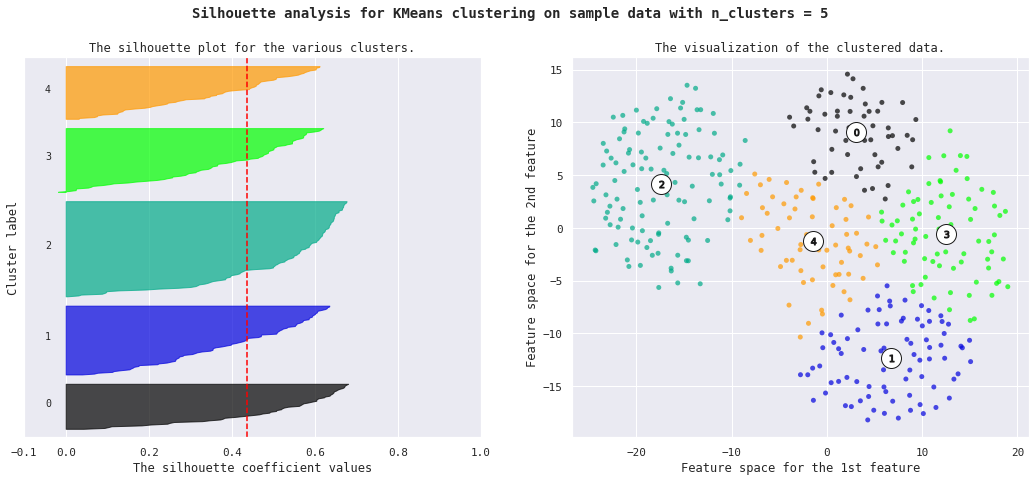

In [213]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

feat_red = dim_reduct_for_plot(data,key='tsne',dim=2)
X = feat_red[:,0:2]
y = np.asarray(pred)
range_n_clusters = range(2,6)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=100, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=400, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### 4. Perform HAC on data and visualize the results
Hierarchical agglomerative clustering (HAC) is the gold standard for clustering in bioinformatics. It combines samples together by distance and linkage metrics. It is not susceptible to the curse of dimensionality like the other algorithms, but is very computationally intensive.

Our script calculates the cophenetic correlation coefficient for every combination of distance and linkage methods. It takes the top ten highest scorers and creates clustered heatmaps from them.

In [ ]:
from sklearn.cluster import AgglomerativeClustering as AC


In [214]:
from scipy.cluster import hierarchy as hrch
from scipy.cluster.hierarchy import cophenet,single,complete,weighted,average,centroid,ward, median



data = pd.read_csv('Datasets/Preprocessed/data_subset_normalized_iqr_99_per.csv',index_col=0)

#dData = downsample_data(copy)
dData = data
dists = ["braycurtis", "canberra", "chebyshev", "cityblock", "correlation", "cosine", "dice", "euclidean", "jensenshannon", "kulsinski", "mahalanobis", "minkowski", "rogerstanimoto", "russellrao", "seuclidean", "sokalmichener", "sokalsneath", "sqeuclidean", "yule"]
distmethdict ={}
for i in dists:
    proximity_matrix = pdist(dData,i)
    try:
        si = single(proximity_matrix)
        co = complete(proximity_matrix)
        av = average(proximity_matrix)
        wt = weighted(proximity_matrix)
        ce = centroid(proximity_matrix)
        wa = ward(proximity_matrix)
        me = median(proximity_matrix)

    except:
        print("Dist: ",i, "Error")
    linkages = [si,co,av,wt,ce,wa,me]
    linkagesnames = ['single','complete','average', 'weighted','centroid','ward', 'median']

    for j in range(len(linkages)):
        cpcc, d =(cophenet(linkages[j],proximity_matrix))
        if not np.isnan(cpcc) and cpcc < .99  and cpcc >= 0:
            x = i + "_" + linkagesnames[j]
            #print(x,':',cpcc)
            distmethdict.update({x:cpcc})
max_key = max(distmethdict,key=distmethdict.get)
# Make sure to pass your dataset into downsample_data() 
# and use the resulting smaller dataset for hierachical clustering

# Pass the down-sampled dataset into scipy.spatial.distance.pdist 
#to get your proximity matrix for calculating CPCC


# the rest of your code goes here


Dist:  jensenshannon Error
Dist:  yule Error


In [215]:
import operator
sorted_d = sorted(distmethdict.items(), key=operator.itemgetter(1))
top_ten = sorted_d[-10:]

top_ten

[('correlation_ward', 0.6867370482889079),
 ('mahalanobis_median', 0.6931949268382296),
 ('mahalanobis_centroid', 0.702800200787874),
 ('cosine_centroid', 0.7043214595067444),
 ('mahalanobis_average', 0.707574273195187),
 ('correlation_complete', 0.7081620287096914),
 ('cosine_average', 0.7157925610536583),
 ('correlation_centroid', 0.7537690634259087),
 ('canberra_average', 0.7787372086041359),
 ('correlation_average', 0.7863020675914262)]

In [201]:
labels1 = pd.read_csv('Datasets/Preprocessed/Alzh_Labels_Wrangled.csv',index_col = 0)



Method:  ward  Linkage:  correlation

Method:  median  Linkage:  mahalanobis

Method:  centroid  Linkage:  mahalanobis

Method:  centroid  Linkage:  cosine

Method:  average  Linkage:  mahalanobis

Method:  complete  Linkage:  correlation

Method:  average  Linkage:  cosine

Method:  centroid  Linkage:  correlation

Method:  average  Linkage:  canberra

Method:  average  Linkage:  correlation


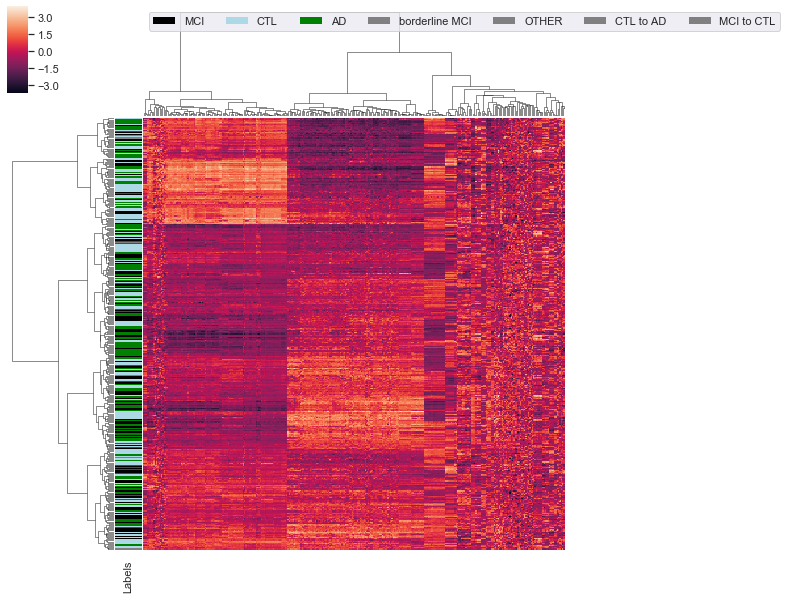

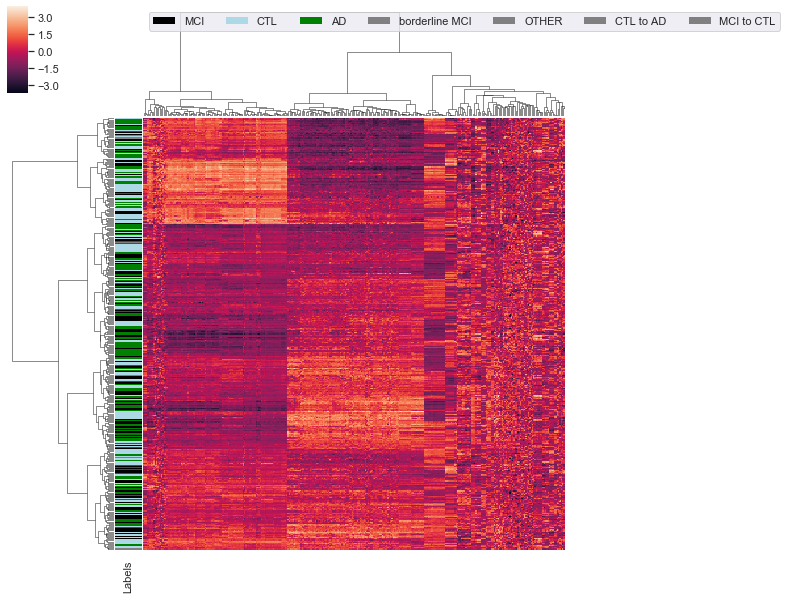

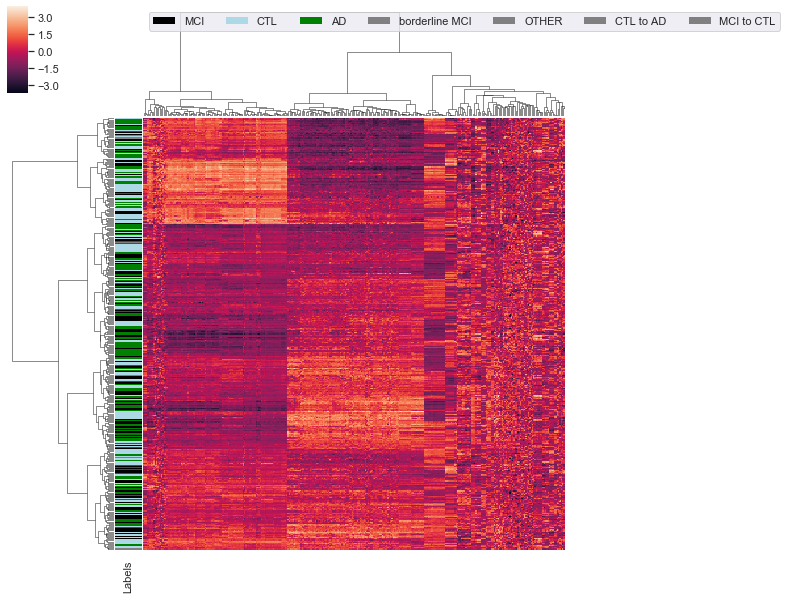

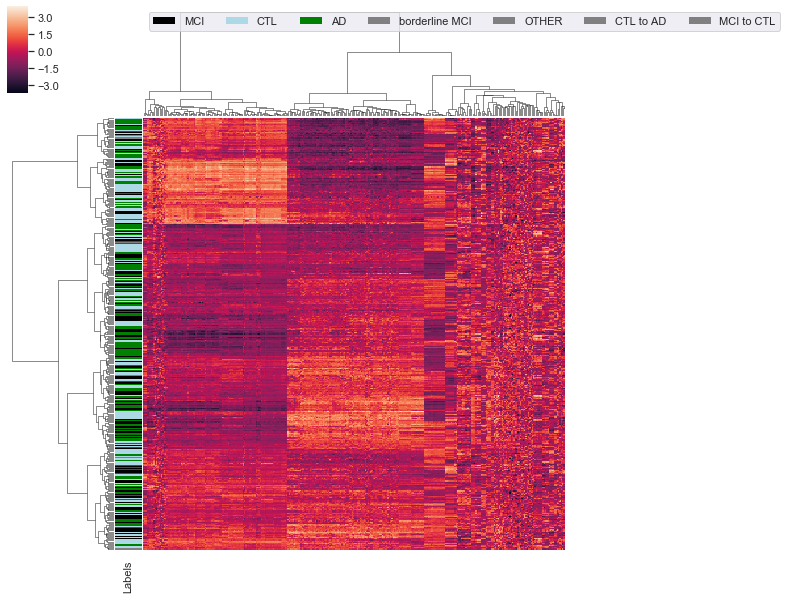

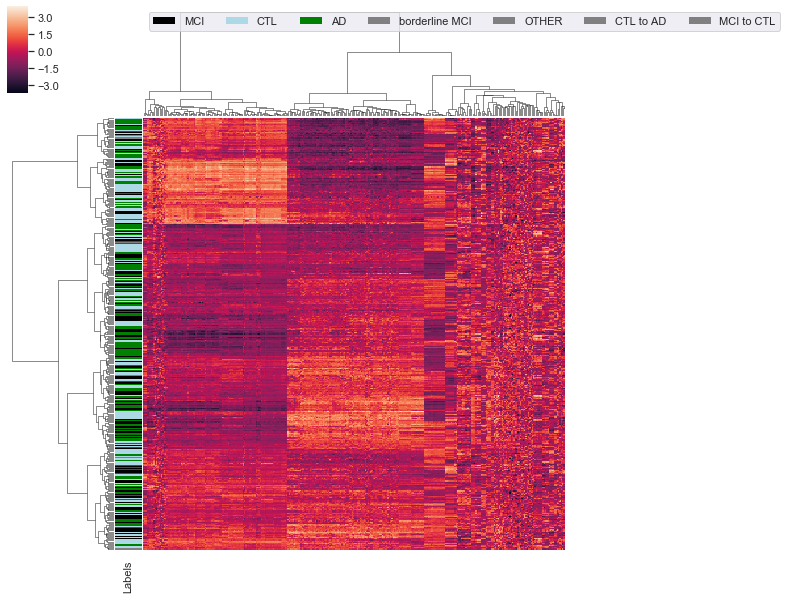

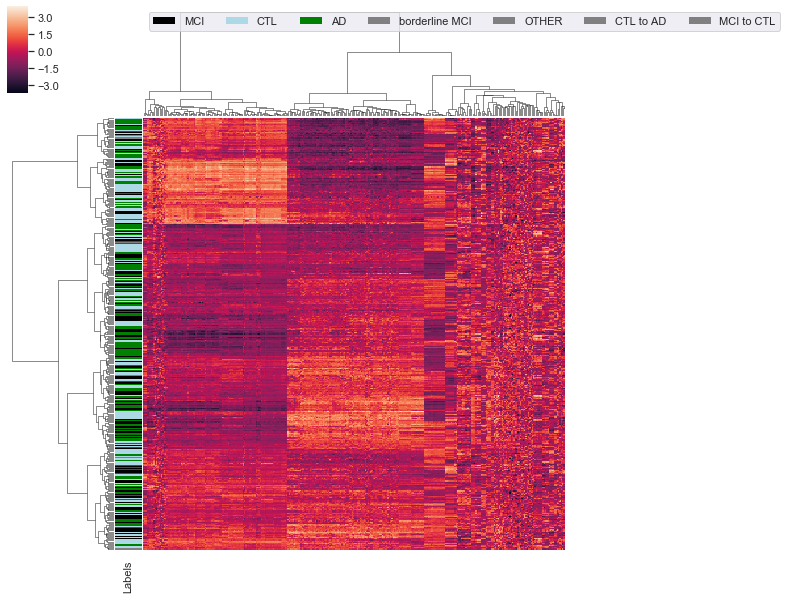

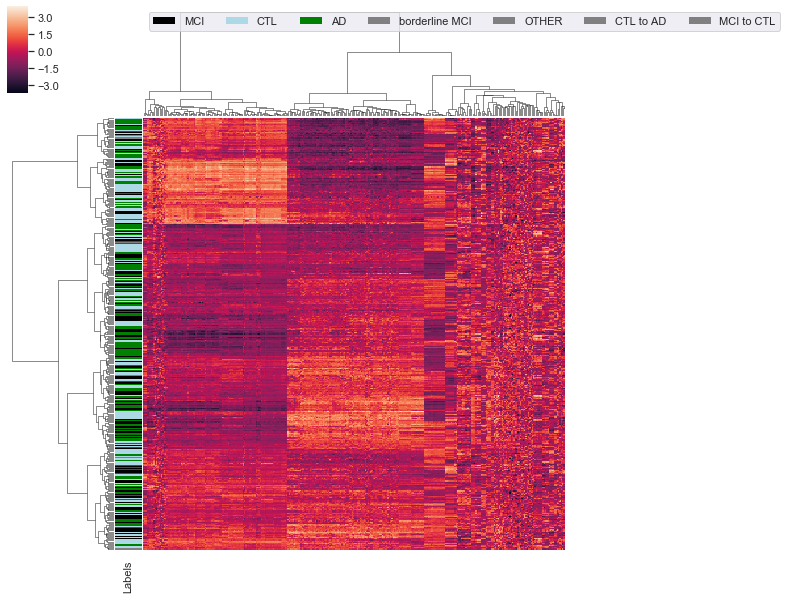

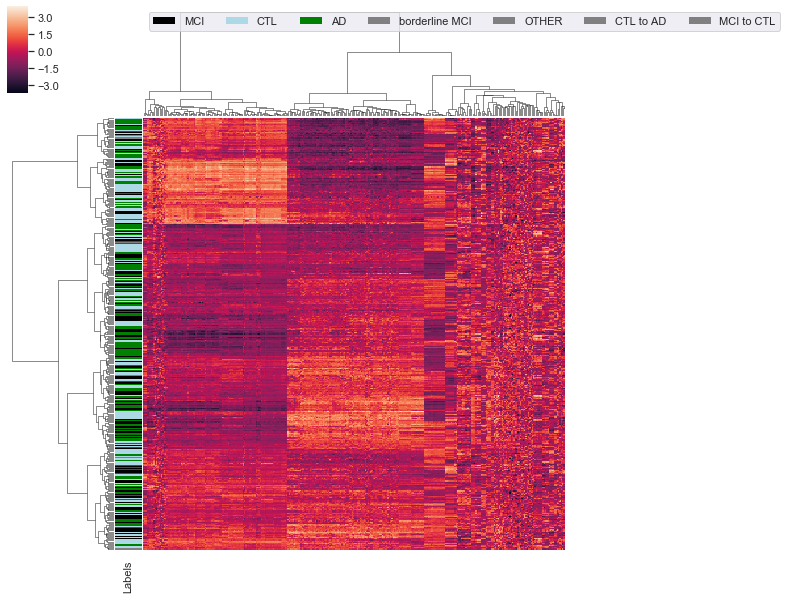

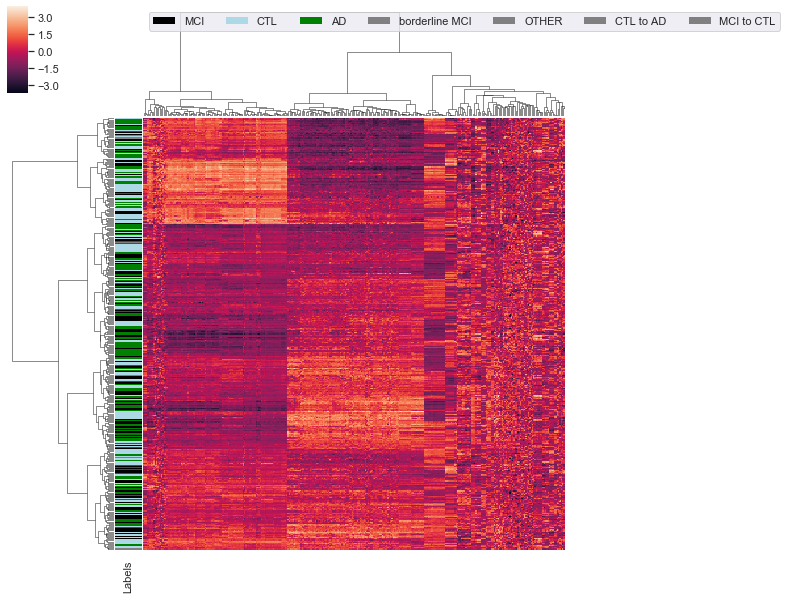

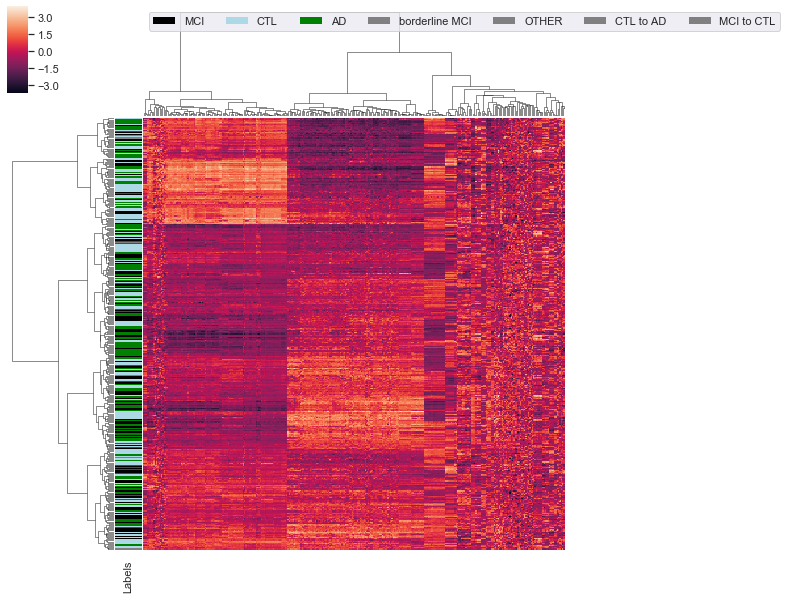

In [77]:
# your code goes here
top_ten = sorted_d[-10:]
for i in range(len(top_ten)):
    top_ten[i] = top_ten[i][0]
#top_ten = [top_ten[0]]
for i in top_ten:
    
    x = i.split('_')
    method = x[0]
    link = x[1]
    proximity_matrix = pdist(dData,method)
    if link == 'single':
        proximity_matrix = single(proximity_matrix)
    if link == 'complete':
        proximity_matrix = complete(proximity_matrix)
    if link == 'average': 
        proximity_matrix = average(proximity_matrix)
    if link == 'weighted':
        proximity_matrix = weighted(proximity_matrix)
    if link == 'centroid':
        proximity_matrix = centroid(proximity_matrix)
    if link == 'ward':
        proximity_matrix = ward(proximity_matrix)
    if link == 'median':
        proximity_matrix = median(proximity_matrix)
    
    
    from scipy.cluster.hierarchy import dendrogram as dend
    #x = fancy_dendrogram(proximity_matrix,max_d=1.1)
    #x = dend(proximity_matrix)
    #plt.savefig('dend.pdf')
    import seaborn as sns; sns.set(color_codes=True)
#     try:
    print()
    print('Method: ',link,' Linkage: ',method)
    data.insert(0, "Labels", labels1, True)
    labels1 = data.pop("Labels")
    lut = dict(zip(labels1.unique(), ['black','#add8e6','green','gray','gray','gray','gray']))
    row_colors = labels1.map(lut)
    GWHM = sns.clustermap(dData,method='ward',metric='euclidean',xticklabels=False,yticklabels=0,row_colors=row_colors)
#     GWHM = sns.clustermap(dData,method=link,metric=method,xticklabels=False,yticklabels=0,row_colors=row_colors)
    for x in labels1.unique():
        GWHM.ax_col_dendrogram.bar(0, 0, color=lut[x],
                                label=x, linewidth=0)
    GWHM.ax_col_dendrogram.legend(loc=2, ncol=100)
#     except ValueError:
#         print('Method and metric incompatible')

These heatmaps are very informative. It is advantageous that they look very similar — this shows that the clusters are 'stable' and exist regardless of the distance and linkage methods used. The heatmaps show two clusters of patients and three clusters of genes.

#### Distance Matrix
Here, we visualize the distance matrix between samples (sorted by cluster identity). This shows us that we have two clusters. One is very strong and the other is more diffuse.

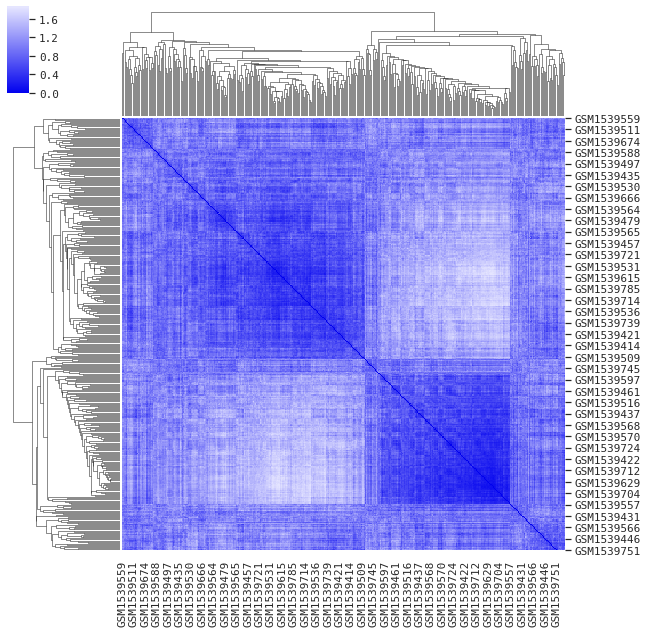

In [78]:
#retrieve cluster label
from sklearn import metrics
import pandas as pd, seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from sklearn.datasets import load_iris
sns.set(font="monospace")

pal = sns.light_palette("#0000EE", as_cmap=True,reverse=True)
#sns.kdeplot(x, y, cmap=pal);
DF_corr = dData.T.corr()
DF_dism = 1 - DF_corr   # distance matrix
linkage = hc.linkage(sp.distance.squareform(DF_dism), method='average',metric='correlation')
sns.clustermap(DF_dism, row_linkage=linkage, col_linkage=linkage,cmap=pal)

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

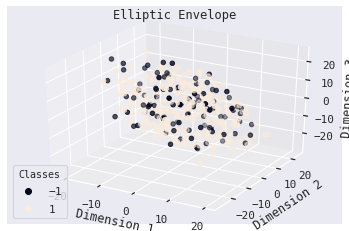

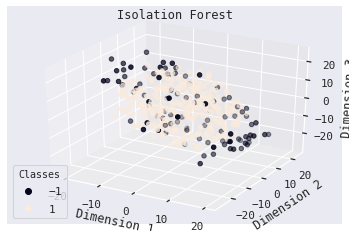

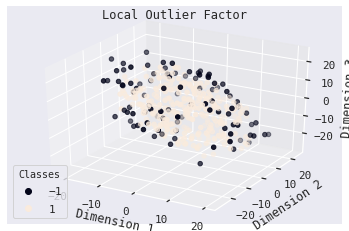

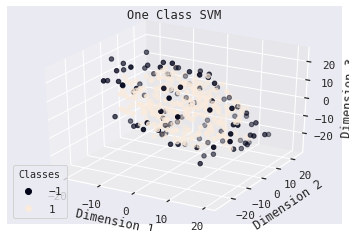

In [107]:
from sklearn.covariance import EllipticEnvelope as EE
from sklearn.ensemble import IsolationForest as IF
from sklearn.neighbors import LocalOutlierFactor as LOF
from sklearn.svm import OneClassSVM as OCS

colors = np.array(['#377eb8', '#ff7f00'])
outliers_fraction = 0.25
X = data
#this will be your list of 16 plots
X_red = dim_reduct_for_plot(X,key='MDS',dim=3)
#apply EllipticEnvelope AD
#append resulting y_pred to y_pred_list
EE_ = EE(contamination = 0.25)
pred = EE_.fit_predict(X)
plot(X_red,pred,dim = 3,title = 'Elliptic Envelope')
    

#apply IsolationForest AD
#append resulting y_pred to y_pred_list
IF_ = IF(contamination = 0.25)
pred = IF_.fit_predict(X)
plot(X_red,pred,dim = 3,title = 'Isolation Forest')

#apply LocalOutlierFactor AD
#append resulting y_pred to y_pred_list
LOF_ = LOF(contamination = 0.25)
pred = LOF_.fit_predict(X)
plot(X_red,pred,dim = 3,title = 'Local Outlier Factor')

#apply OneClassSVM AD
#append resulting y_pred to y_pred_list
OCS_ = OCS(nu = 0.25, kernel = 'rbf')
pred = OCS_.fit_predict(X)
plot(X_red,pred,dim = 3,title = 'One Class SVM')
 

# plot_all(y_pred_list)